In [1]:
# Import dependencies
import pandas as pd
import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey

import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style

from flask import Flask, jsonify

style.use('seaborn')


In [2]:
#create engine and conn
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
#will get the column names and type using inspect 
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'station', 'stations']

In [4]:

# Get a list of column names and types
columns = inspector.get_columns('Measurements')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date DATE
prcp FLOAT
tobs FLOAT


In [5]:
engine.execute("select * from measurements limit 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-07', 0.06, 70.0)]

# Select prcp & date for the last 12 months
results = conn.execute('select * from measurements order by date').first()
results


In [6]:
# Save reference to the tables
#Measurements = Base.classes.measurements
#Stations = Base.classes.stations

# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurements = Base.classes.measurements

In [7]:
# Start a session to query the database
session = Session(engine)

In [10]:
# Grabs the last date entry in the data table
last_date1 = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date1)

(datetime.date(2017, 8, 23),)


In [11]:
# to get the last 12 months of data, last date - 365
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [12]:
# query to pull the last year of precipitation data
rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [13]:
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


In [14]:
rain_df.set_index("date").head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


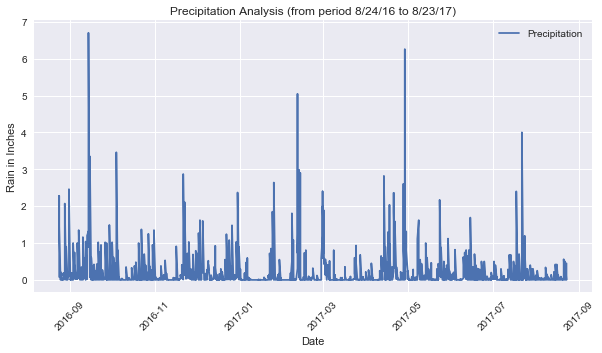

In [16]:

# plot the dataframe

rain_df.plot('date', 'prcp')

plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (from period 8/24/16 to 8/23/17)")
plt.legend(["Precipitation"], loc="best")
plt.xticks(rotation=45)

plt.rcParams["figure.figsize"] = [10,5]

plt.savefig('prec.png')
plt.show()

In [ ]:

# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

In [18]:
#Design a query to calculate the total number of stations.
loctions = session.query(Measurements).group_by(Measurements.station).count()
print(" total number of {} stations.".format(loctions))

 total number of 9 stations.


In [24]:
#Design a query to find the most active stations.
active_st = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()
    
activestation = active_st[0][0]  
print("active Station",activestation,"with",active_st[0][1],"weather observations.\n")
print("Stations in descending order with their number of observations:")
for station, count in active_st:
    print("Station:",station,  "weather observations:", count)

active Station USC00519281 with 2772 weather observations.

Stations in descending order with their number of observations:
Station: USC00519281 weather observations: 2772
Station: USC00513117 weather observations: 2696
Station: USC00519397 weather observations: 2685
Station: USC00519523 weather observations: 2572
Station: USC00516128 weather observations: 2484
Station: USC00514830 weather observations: 1937
Station: USC00511918 weather observations: 1932
Station: USC00517948 weather observations: 683
Station: USC00518838 weather observations: 342


In [26]:

# query to pull the last year of precipitation data for the busiest station
temp = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == activestation).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

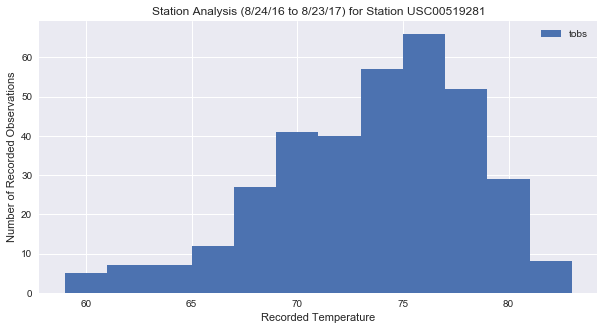

In [27]:
# plot the temperature data in a histogram with 12 bins
temperature_df=pd.DataFrame(temp)
plt.hist(temperature_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + activestation)
plt.legend(["tobs"], loc="best")

plt.savefig("temp.png")
plt.show()

In [28]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
      
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
    


In [29]:
#Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the 
#matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
temp_range = (calc_temps('2012-02-28', '2012-03-05'))

print(temp_range)

[(62.0, 69.3921568627451, 74.0)]


In [30]:

# calculate the min/max/avg from last year that matches my trip date
trip_arrive = dt.date(2018, 5, 10)
trip_leave = dt.date(2018, 5, 25)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)
print(temp_avg_lst_year[0][0])
print(temp_avg_lst_year[0][1])
print(temp_avg_lst_year[0][2])

[(68.0, 74.82352941176471, 87.0)]
68.0
74.82352941176471
87.0


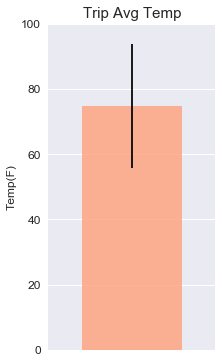

In [38]:
#Temp Analysis

fontsize=12
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]
err = max_temp - min_temp

# plot min max and average into bar chart, with max-min as the yerr
fig, ax = plt.subplots(figsize=(3,6))
ax.bar(.5,avgtemp,.6,color='lightsalmon',alpha = .8,yerr=err)
ax.grid(axis='x')
ax.set_xlim(0,1)
ax.set_xticks([])
ax.set_ylabel('Temp(F)',fontsize=fontsize)
ax.set_ylim(0,100)
plt.yticks(fontsize=fontsize)
plt.title('Trip Avg Temp',fontsize=fontsize+3)

plt.savefig('trip.png')
plt.show()